### Import Libraries

In [29]:
import os, glob, cv2, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

### Check unmatched images and labels

In [16]:
import os, glob
from pathlib import Path

IMAGES_DIR = "coco128/images/train2017"
LABELS_DIR = "coco128/labels/train2017"

image_files = sorted([Path(p).stem for p in glob.glob(os.path.join(IMAGES_DIR, "*"))])
label_files = sorted([Path(p).stem for p in glob.glob(os.path.join(LABELS_DIR, "*"))])

print(f"{len(image_files)} images found")
print(f"{len(label_files)} labels found")

common = set(image_files).intersection(set(label_files))
print(f"{len(common)} matched pairs")

# show some mismatches
print("First few unmatched images:", list(set(image_files) - set(label_files))[:5])
print("First few unmatched labels:", list(set(label_files) - set(image_files))[:5])


128 images found
128 labels found
126 matched pairs
First few unmatched images: ['000000000250', '000000000508']
First few unmatched labels: ['000000000656', '000000000659']


### Set configurations

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 224
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_EPOCHS = 20

### Convert YOLO TXT annotations -> segmentation masks

In [ ]:
IMAGES_DIR = "coco128/images/train2017"
LABELS_DIR = "coco128/labels/train2017"
OUT_MASKS_DIR = "coco128/masks/train2017"
os.makedirs(OUT_MASKS_DIR, exist_ok=True)

img_paths = list(Path(IMAGES_DIR).glob("*.jpg"))
for img_path in tqdm(img_paths, desc="Converting YOLO -> masks"):
    name = img_path.stem
    txt_path = Path(LABELS_DIR) / f"{name}.txt"
    if not txt_path.exists():
        continue
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5: 
                continue
            cls, xc, yc, bw, bh = map(float, parts)
            cls = int(cls)
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w-1, x2), min(h-1, y2)
            cv2.rectangle(mask, (x1, y1), (x2, y2), color=cls+1, thickness=-1)
    cv2.imwrite(str(Path(OUT_MASKS_DIR)/f"{name}.png"), mask)
print(f"Conversion complete! Masks saved to {OUT_MASKS_DIR}")

In [ ]:
### Dataset class

In [ ]:
class CocoLikeSegDataset(Dataset):
    def __init__(self, images_dir, labels_dir, input_size=224):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.input_size = input_size

        img_files = {Path(p).stem: p for p in glob.glob(str(self.images_dir/"*"))}
        lbl_files = {Path(p).stem: p for p in glob.glob(str(self.labels_dir/"*"))}
        common = sorted(set(img_files.keys()).intersection(lbl_files.keys()))
        self.samples = [(img_files[n], lbl_files[n]) for n in common]
        if len(self.samples)==0:
            raise RuntimeError("No matched pairs found.")

        self.img_tf = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])
        self.lbl_tf = transforms.Resize((input_size,input_size), interpolation=Image.NEAREST)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_p, lbl_p = self.samples[idx]
        image = Image.open(img_p).convert("RGB")
        label = Image.open(lbl_p)
        image = self.img_tf(image)
        label = transforms.Resize((self.input_size,self.input_size), interpolation=Image.NEAREST)(label)
        label = torch.from_numpy(np.array(label, dtype=np.int64))
        return image, label

from PIL import Image 

### FCN model variants

In [ ]:
class FCN(nn.Module):
    def __init__(self, variant="fcn32", num_classes=21, upsample="transpose"):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        layers = list(backbone.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        for p in self.backbone.parameters():
            p.requires_grad = False

        self.score_conv = nn.Conv2d(2048, num_classes, kernel_size=1)
        self.variant = variant
        self.upsample_mode = upsample

        # Transpose or bilinear upsampler
        if upsample == "transpose":
            if variant == "fcn32":
                self.up = nn.ConvTranspose2d(num_classes, num_classes, 64, 32, 16)
            elif variant == "fcn16":
                self.up = nn.ConvTranspose2d(num_classes, num_classes, 32, 16, 8)
            else:
                self.up = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4)
        else:
            scale = 32 if variant == "fcn32" else 16 if variant == "fcn16" else 8
            self.up = nn.Upsample(scale_factor=scale, mode="bilinear", align_corners=False)

    def forward(self, x):
        input_size = x.shape[2:]  # (H, W)
        x = self.backbone(x)
        x = self.score_conv(x)
        x = self.up(x)
        # Force output to same size as input
        x = F.interpolate(x, size=input_size, mode="bilinear", align_corners=False)
        return x

### Metrics and evaluation

In [ ]:
def pixel_accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    correct = (pred==target).float().sum()
    total = torch.numel(target)
    return (correct/total).item()

def mean_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_i = (pred==cls)
        tgt_i = (target==cls)
        inter = (pred_i & tgt_i).sum().float()
        union = (pred_i | tgt_i).sum().float()
        if union>0:
            ious.append((inter/union).item())
    return np.mean(ious) if ious else 0.0

@torch.no_grad()
def evaluate(model, loader, criterion, device, num_classes):
    model.eval()
    total_loss, pixacc, miou, n = 0, 0, 0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(imgs)
        loss = criterion(out, masks)
        total_loss += loss.item()*imgs.size(0)
        pixacc += pixel_accuracy(out, masks)*imgs.size(0)
        miou += mean_iou(out, masks, num_classes)*imgs.size(0)
        n += imgs.size(0)
    return total_loss/n, pixacc/n, miou/n

### Training loop

In [ ]:
def run_experiment(train_loader, val_loader, num_classes, model_name, upsample_mode, optimizer_name, device, epochs=20):
    model = FCN(model_name, num_classes, upsample=upsample_mode).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) if optimizer_name=="adam" else torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    hist = {"epoch":[], "train_loss":[], "val_loss":[], "val_pixacc":[], "val_miou":[]}

    for ep in range(1, epochs+1):
        model.train()
        train_loss=0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*imgs.size(0)
        train_loss /= len(train_loader.dataset)
        val_loss, pixacc, miou = evaluate(model, val_loader, criterion, device, num_classes)
        hist["epoch"].append(ep)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_pixacc"].append(pixacc)
        hist["val_miou"].append(miou)
        print(f"Epoch {ep}/{epochs}: Train {train_loss:.3f}, Val {val_loss:.3f}, PA {pixacc:.3f}, mIoU {miou:.3f}")
    return model, hist

### Utility: infer num_classes

In [ ]:
def infer_num_classes(dataset):
    maxv=0
    for _,lbl_path in tqdm(dataset.samples, desc="inferring classes"):
        arr = np.array(Image.open(lbl_path))
        maxv = max(maxv, arr.max())
    return int(maxv+1)

### Visualization

In [ ]:
@torch.no_grad()
def visualize_results(model, dataset, device, n=3, num_classes=5):
    model.eval()
    idxs = np.random.choice(len(dataset), n, replace=False)
    for idx in idxs:
        img, mask = dataset[idx]
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        img_np = img.permute(1,2,0).numpy()*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])
        img_np = np.clip(img_np,0,1)
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(mask, cmap="nipy_spectral"); plt.title("GT Mask"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred, cmap="nipy_spectral"); plt.title("Predicted"); plt.axis("off")
        plt.show()

### Train models

In [30]:
def train_all_models():
    dataset = CocoLikeSegDataset(IMAGES_DIR, OUT_MASKS_DIR, input_size=INPUT_SIZE)
    num_classes = infer_num_classes(dataset)
    print(f"Dataset size {len(dataset)}, classes={num_classes}")

    # Split train/validation
    n_train = int(len(dataset) * 0.8)
    train_ds, val_ds = random_split(dataset, [n_train, len(dataset) - n_train])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model_names = ["fcn32", "fcn16", "fcn8"]
    upsample_modes = ["transpose", "bilinear"]
    optimizers = ["adam", "sgd"]

    results = []
    histories = {}
    trained_models = {}  # ✅ renamed from 'models' to avoid conflict with torchvision.models

    for mname in model_names:
        for up in upsample_modes:
            for opt in optimizers:
                print(f"\n\n########## START EXP: {mname} {up} {opt}")
                model, hist = run_experiment(train_loader, val_loader, num_classes, mname, up, opt, DEVICE, epochs=NUM_EPOCHS)
                criterion = nn.CrossEntropyLoss()
                val_loss, val_pixacc, val_miou = evaluate(model, val_loader, criterion, DEVICE, num_classes)

                results.append({
                    "Model": mname,
                    "Upsample": up,
                    "Optimizer": opt,
                    "Val_Loss": val_loss,
                    "Pixel_Acc": val_pixacc,
                    "Mean_IoU": val_miou
                })

                key = f"{mname}_{up}_{opt}"
                histories[key] = hist
                trained_models[key] = model  # ✅ use new variable

                # Save weights
                torch.save(model.state_dict(), f"best_{key}.pth")

    results_df = pd.DataFrame(results)
    results_df.to_csv("fcn_summary.csv", index=False)
    print("\n✅ Training complete. Summary saved to fcn_summary.csv")

    return results_df, histories, trained_models, val_ds, num_classes


# ---- Run this segment to train all models ----
results_df, histories, trained_models, val_ds, num_classes = train_all_models()
display(results_df)


inferring classes: 100%|██████████| 126/126 [00:00<00:00, 420.76it/s]


Dataset size 126, classes=81


########## START EXP: fcn32 transpose adam
Epoch 1/20: Train 3.319, Val 3.050, PA 0.501, mIoU 0.074
Epoch 2/20: Train 2.213, Val 3.086, PA 0.519, mIoU 0.064
Epoch 3/20: Train 1.971, Val 2.893, PA 0.541, mIoU 0.083
Epoch 4/20: Train 1.806, Val 2.886, PA 0.523, mIoU 0.073
Epoch 5/20: Train 1.821, Val 2.988, PA 0.526, mIoU 0.076
Epoch 6/20: Train 1.625, Val 2.980, PA 0.530, mIoU 0.060
Epoch 7/20: Train 1.492, Val 3.726, PA 0.533, mIoU 0.079
Epoch 8/20: Train 1.369, Val 2.672, PA 0.526, mIoU 0.066
Epoch 9/20: Train 1.248, Val 2.844, PA 0.519, mIoU 0.059
Epoch 10/20: Train 1.177, Val 2.696, PA 0.544, mIoU 0.056
Epoch 11/20: Train 1.012, Val 2.848, PA 0.523, mIoU 0.055
Epoch 12/20: Train 1.001, Val 2.790, PA 0.531, mIoU 0.068
Epoch 13/20: Train 0.947, Val 2.791, PA 0.496, mIoU 0.040
Epoch 14/20: Train 0.855, Val 3.101, PA 0.531, mIoU 0.067
Epoch 15/20: Train 0.900, Val 3.836, PA 0.538, mIoU 0.074
Epoch 16/20: Train 1.043, Val 3.456, PA 0.522, mIoU 0.060
Epoch 1

Model   Upsample Optimizer  Val_Loss  Pixel_Acc  Mean_IoU
0   fcn32  transpose      adam  3.067571   0.537515  0.058937
1   fcn32  transpose       sgd  2.633608   0.509010  0.059953
2   fcn32   bilinear      adam  3.340498   0.547937  0.106910
3   fcn32   bilinear       sgd  2.627441   0.513356  0.086225
4   fcn16  transpose      adam  3.415297   0.554795  0.083694
5   fcn16  transpose       sgd  2.684976   0.518410  0.063295
6   fcn16   bilinear      adam  3.481337   0.538260  0.085292
7   fcn16   bilinear       sgd  3.299095   0.513838  0.081400
8    fcn8  transpose      adam  3.037807   0.529748  0.073652
9    fcn8  transpose       sgd  2.714854   0.540939  0.081996
10   fcn8   bilinear      adam  3.376375   0.552319  0.097555
11   fcn8   bilinear       sgd  3.080625   0.537961  0.086089

### Plot training/validation loss and metrics

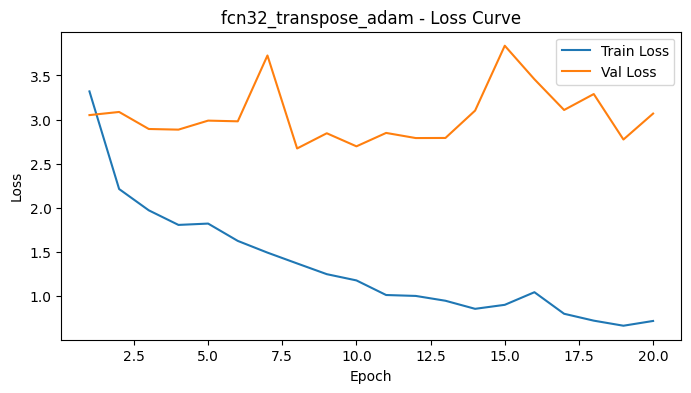

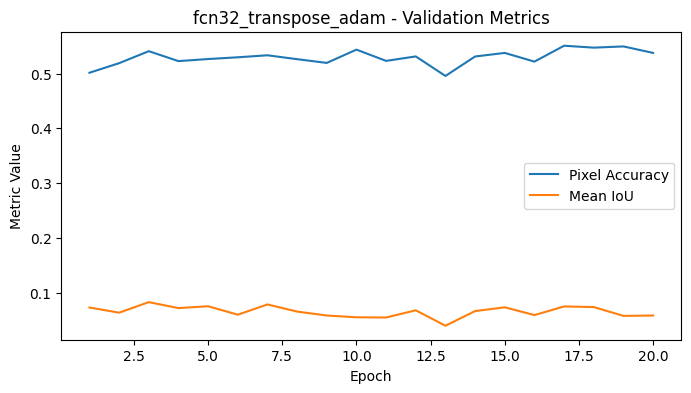

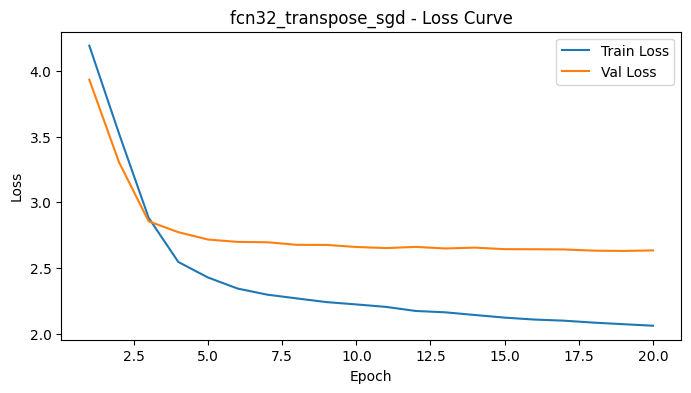

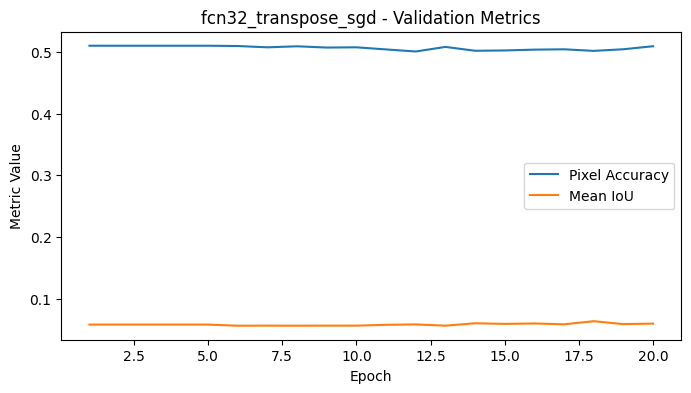

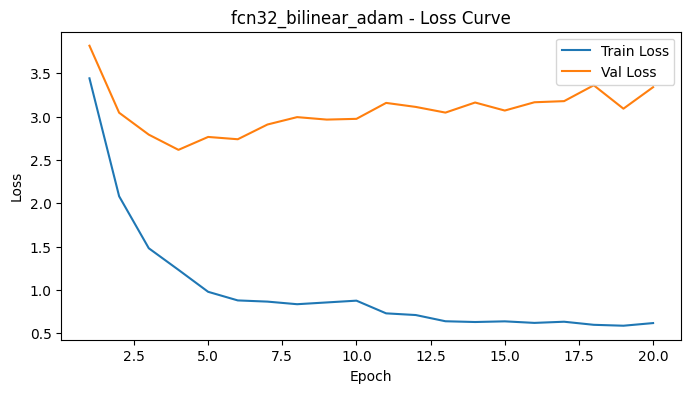

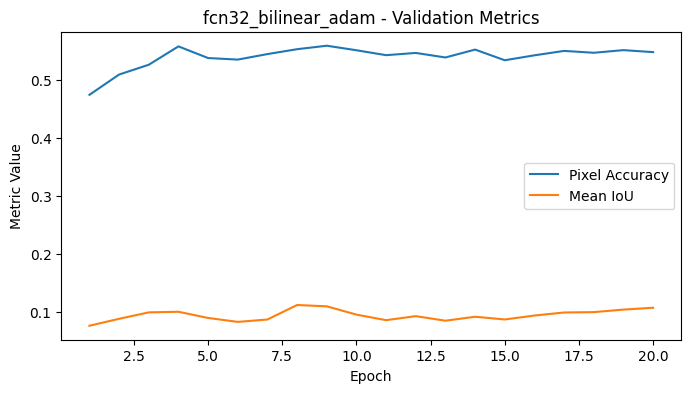

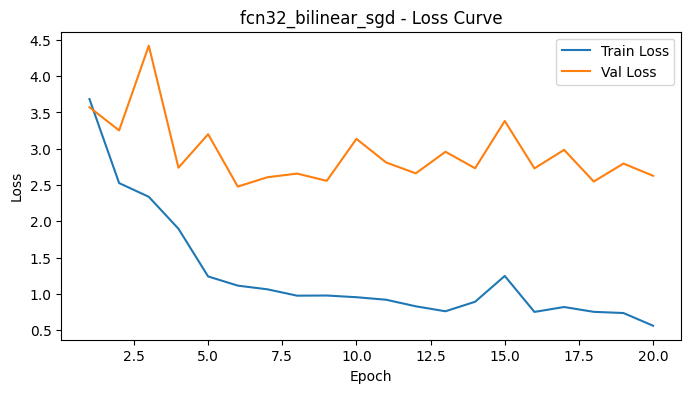

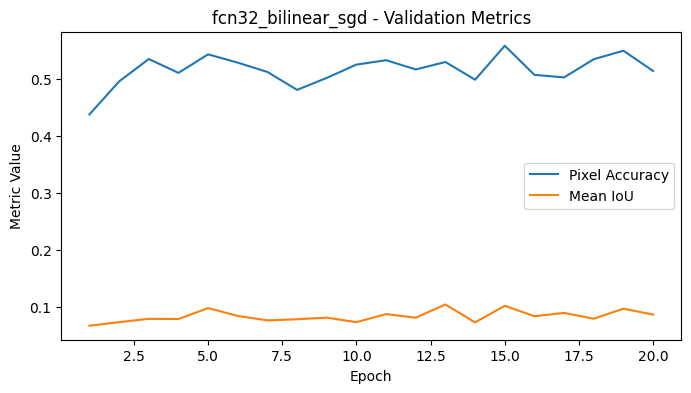

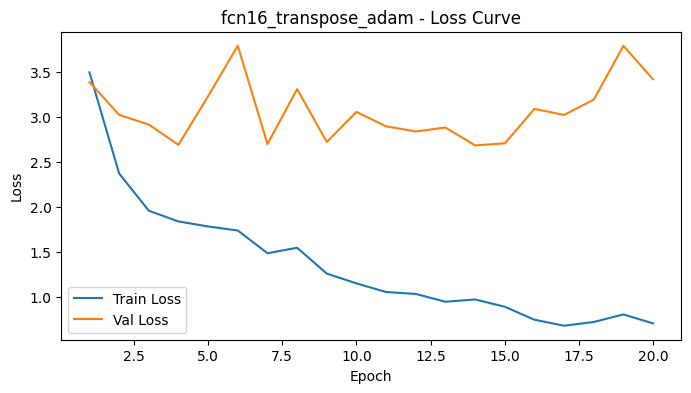

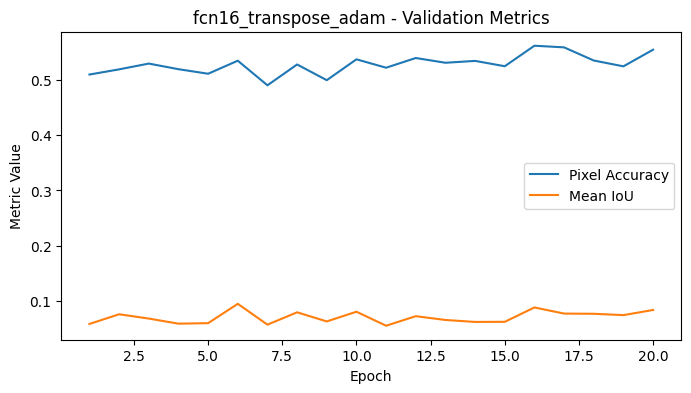

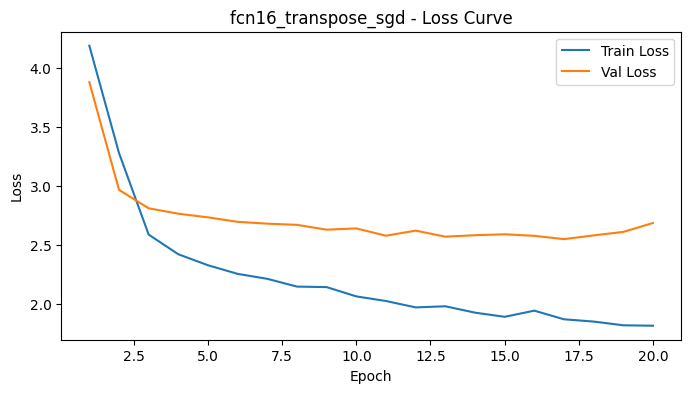

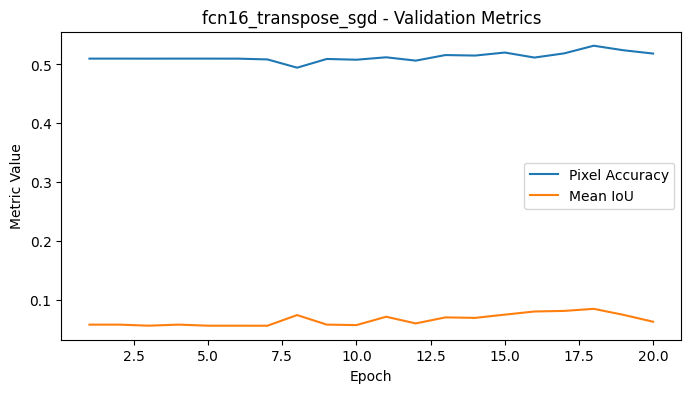

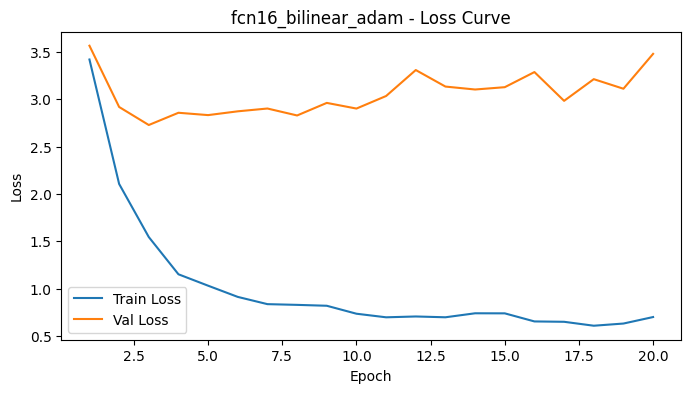

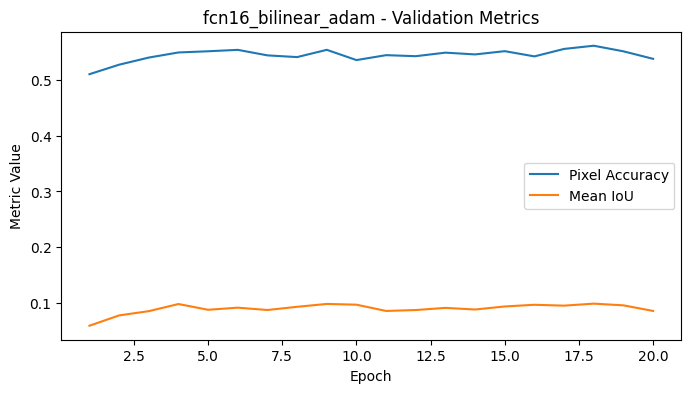

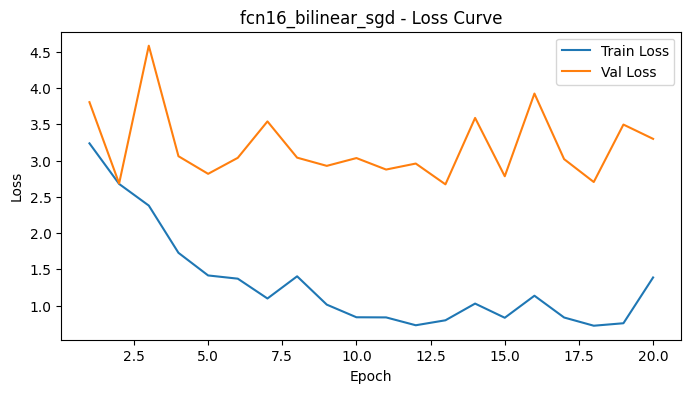

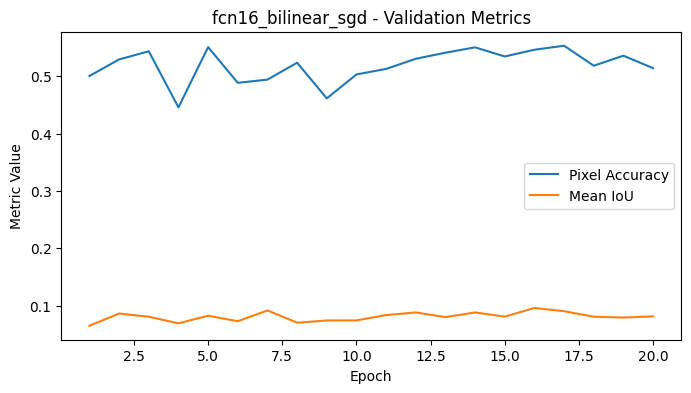

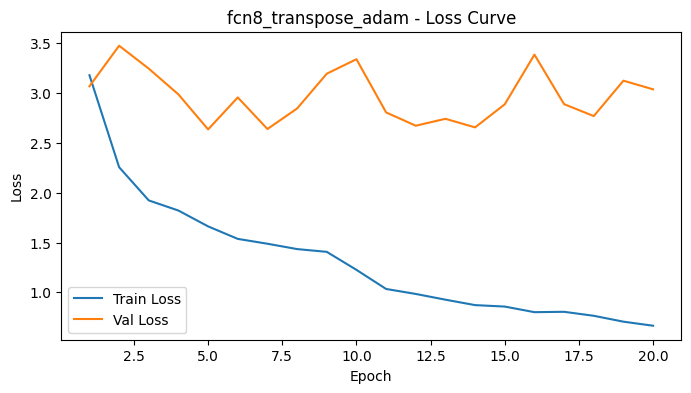

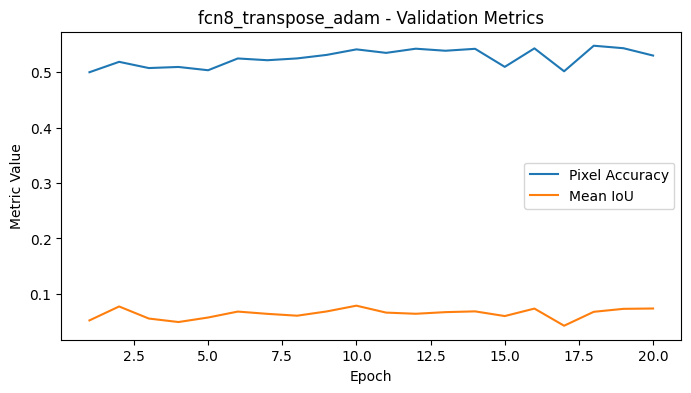

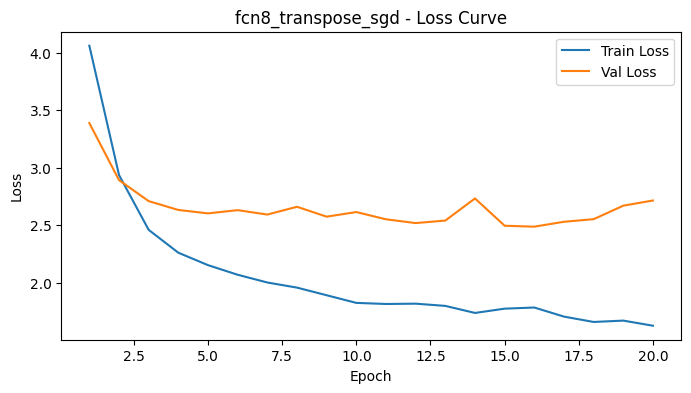

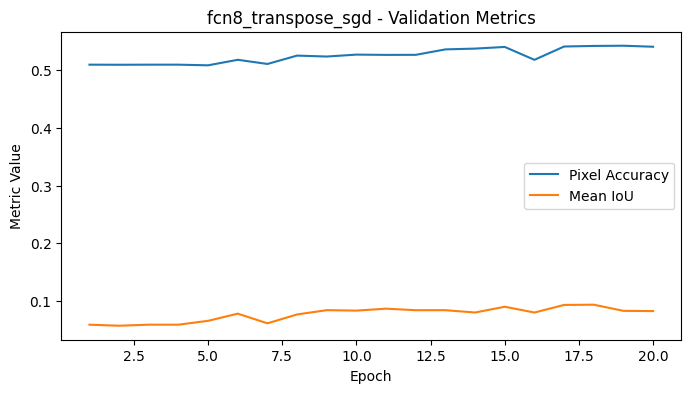

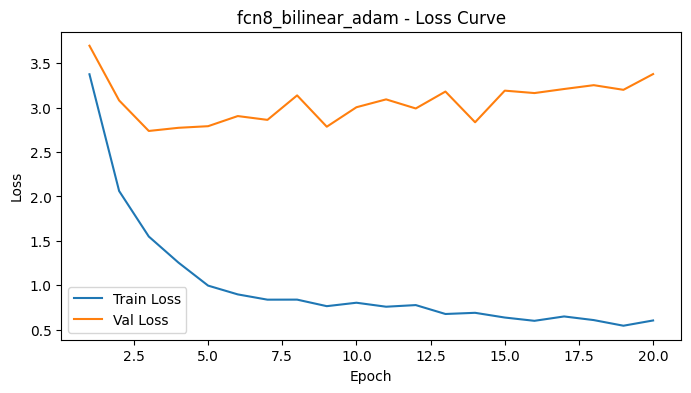

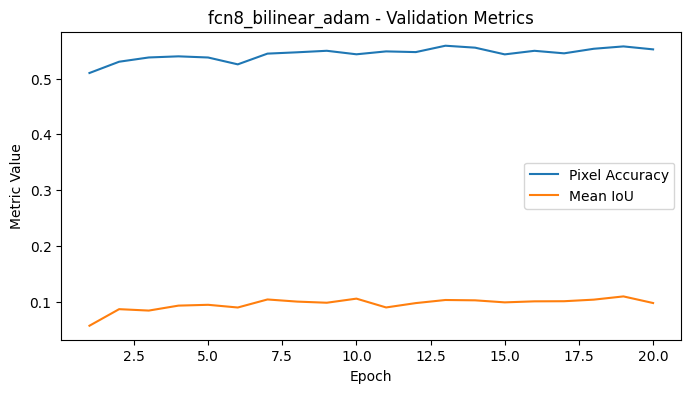

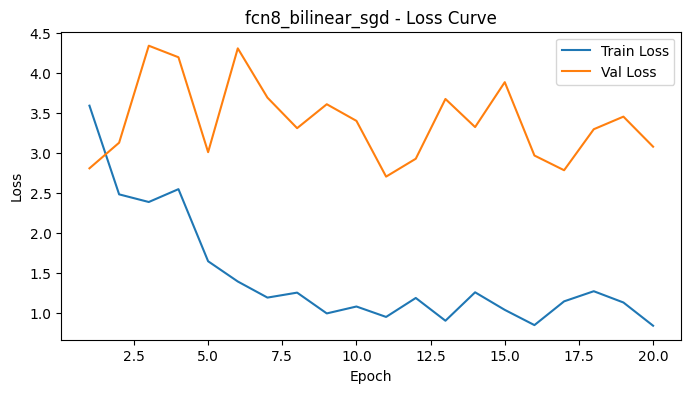

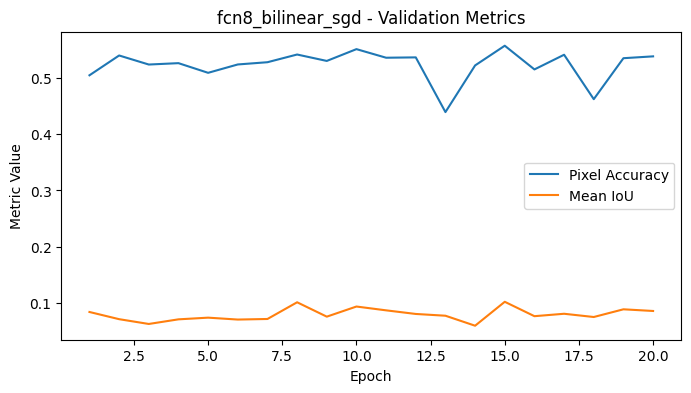

In [31]:
def plot_training_curves(histories):
    for key, h in histories.items():
        plt.figure(figsize=(8, 4))
        plt.plot(h["epoch"], h["train_loss"], label="Train Loss")
        plt.plot(h["epoch"], h["val_loss"], label="Val Loss")
        plt.title(f"{key} - Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.plot(h["epoch"], h["val_pixacc"], label="Pixel Accuracy")
        plt.plot(h["epoch"], h["val_miou"], label="Mean IoU")
        plt.title(f"{key} - Validation Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.show()

# ---- Run this segment to see curves ----
plot_training_curves(histories)


### Visualize segmentation results


Visualization for fcn32_transpose_adam


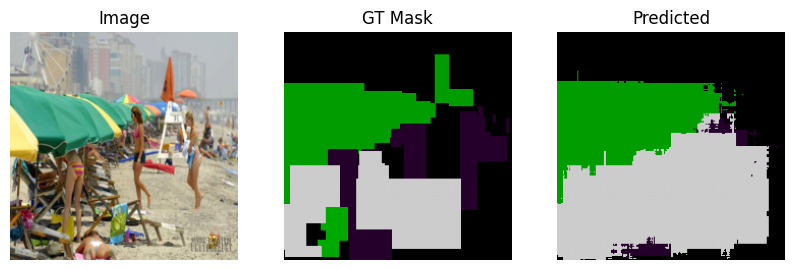

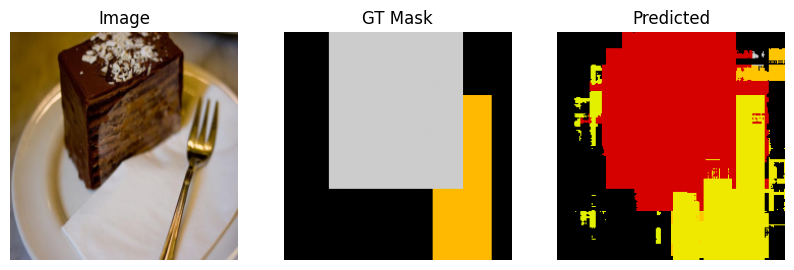

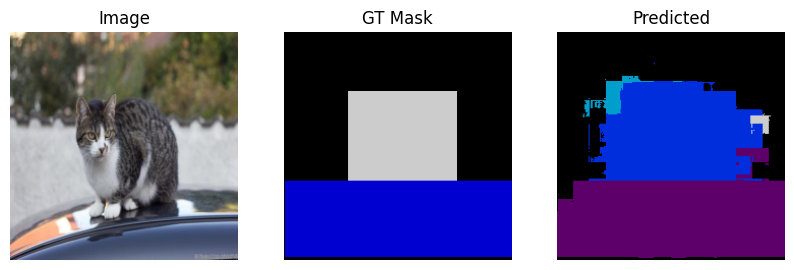


Visualization for fcn32_transpose_sgd


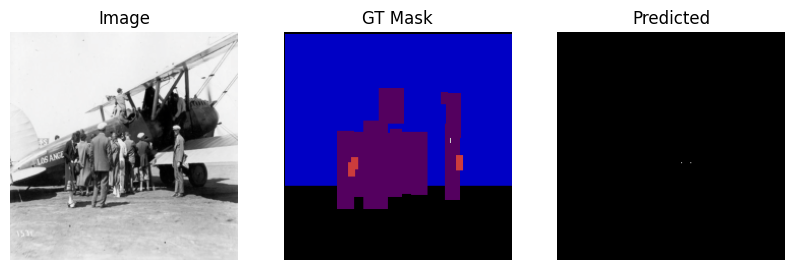

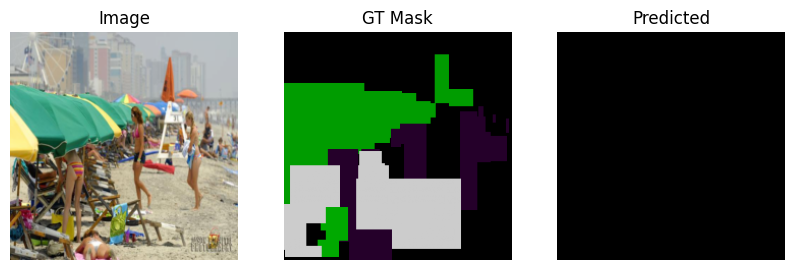

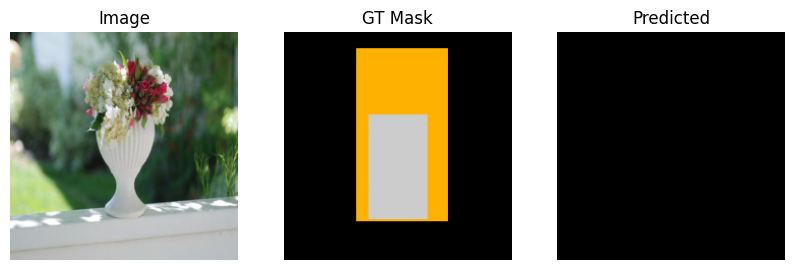


Visualization for fcn32_bilinear_adam


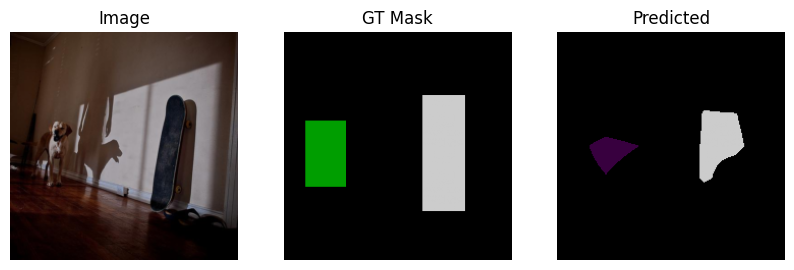

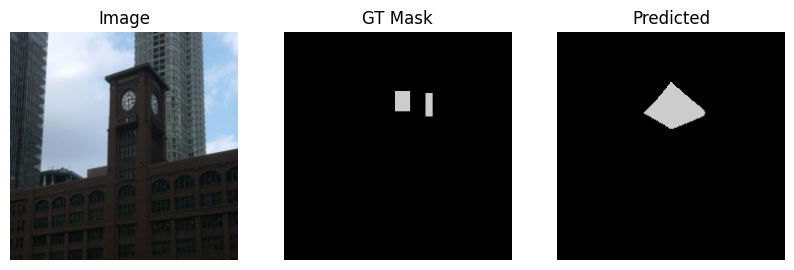

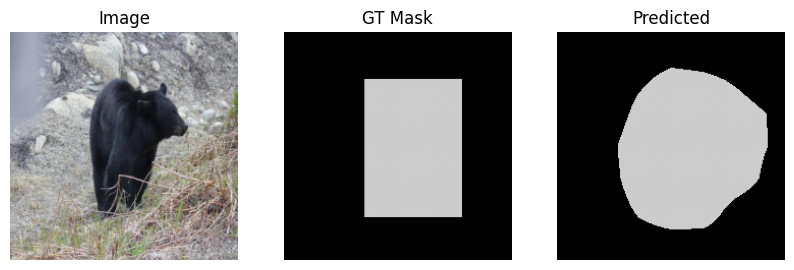


Visualization for fcn32_bilinear_sgd


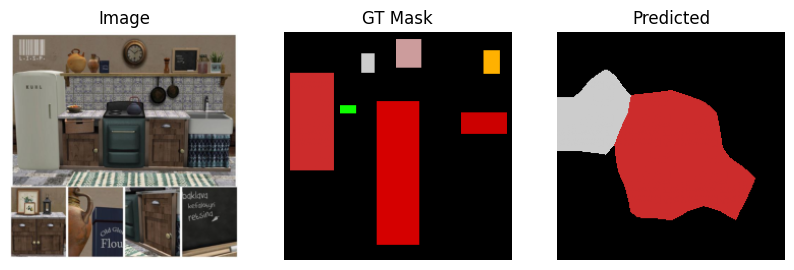

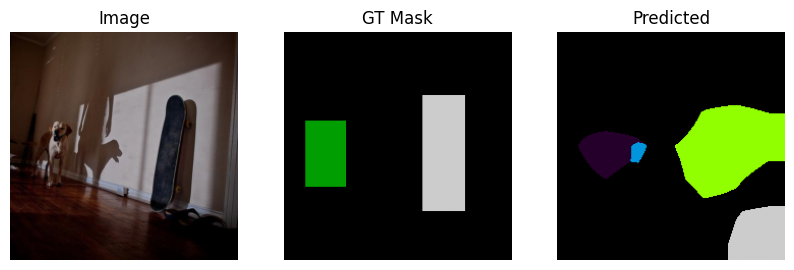

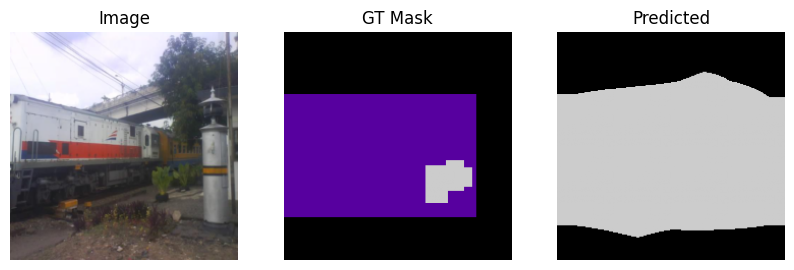


Visualization for fcn16_transpose_adam


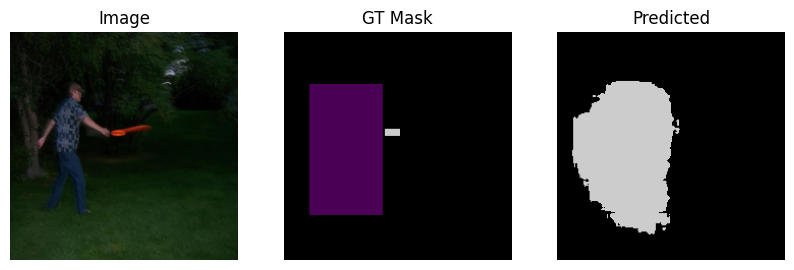

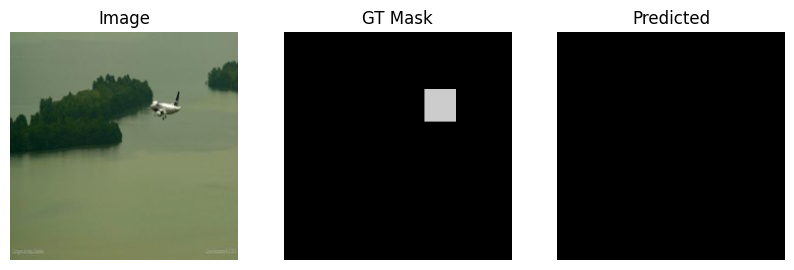

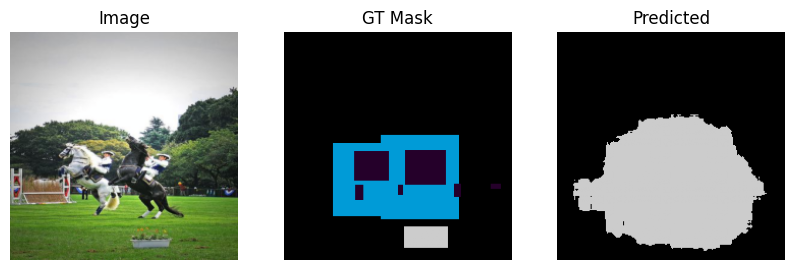


Visualization for fcn16_transpose_sgd


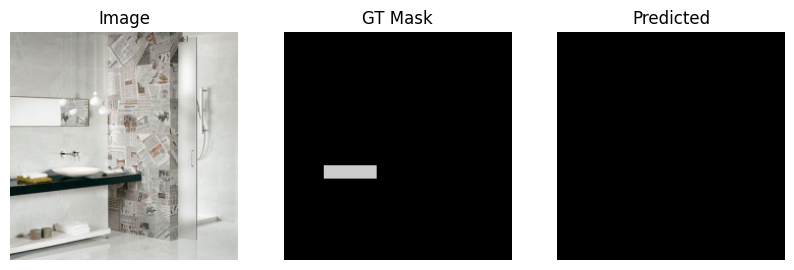

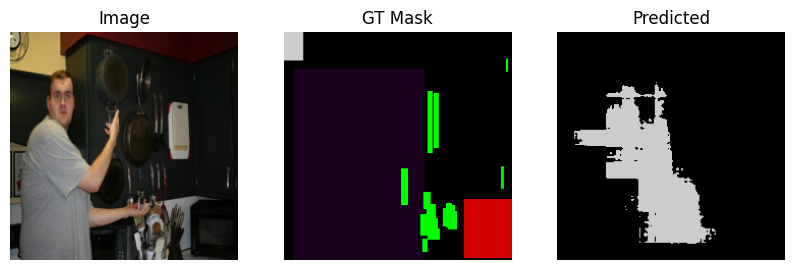

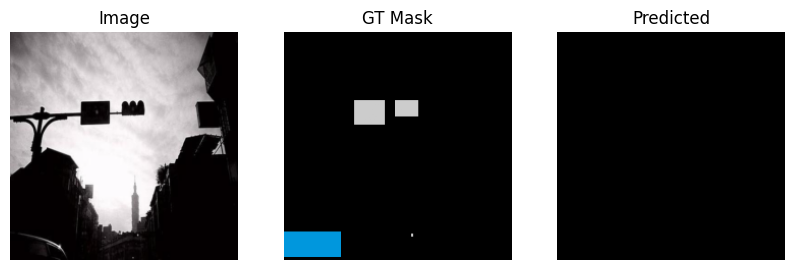


Visualization for fcn16_bilinear_adam


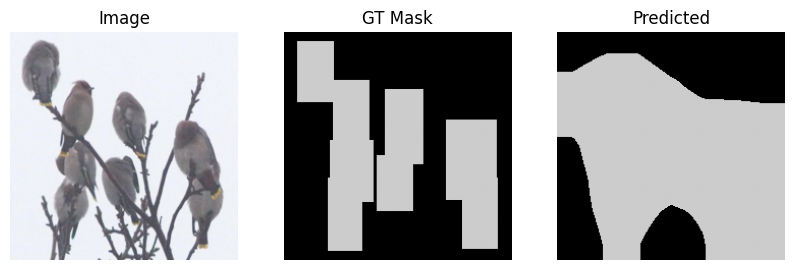

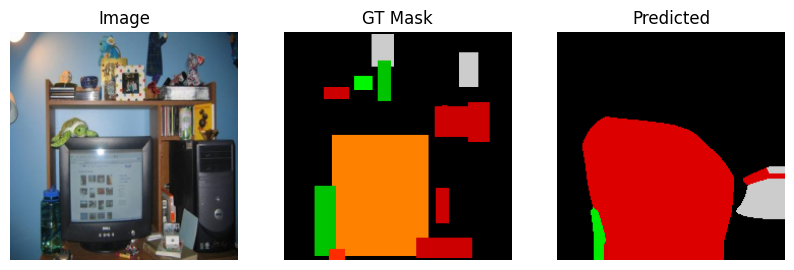

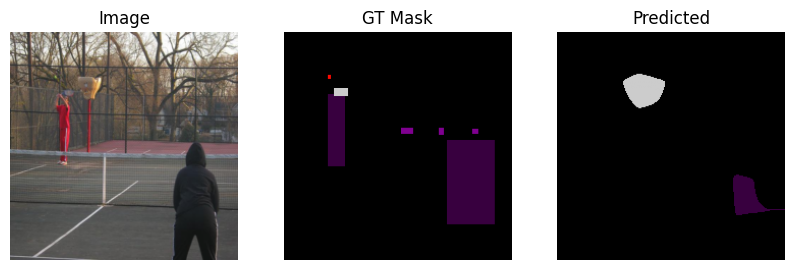


Visualization for fcn16_bilinear_sgd


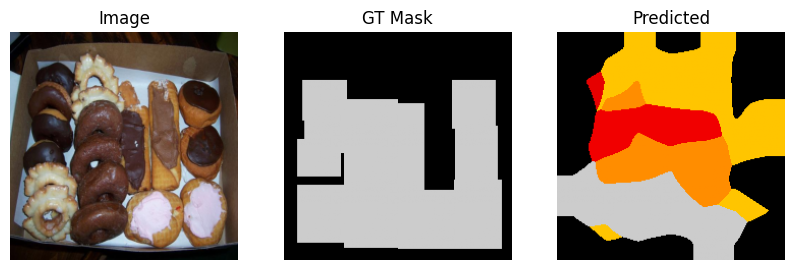

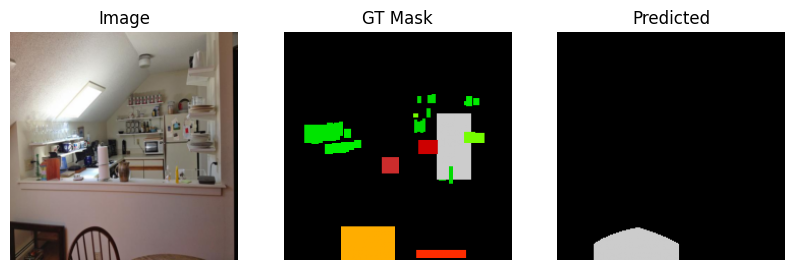

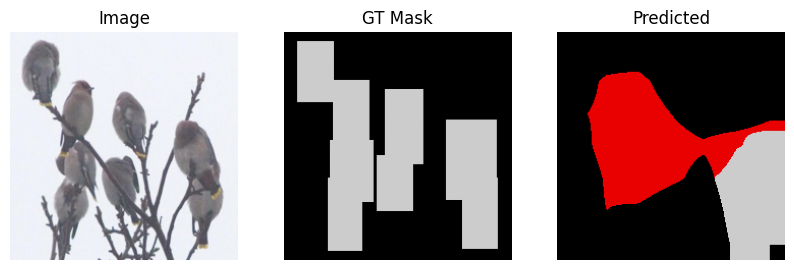


Visualization for fcn8_transpose_adam


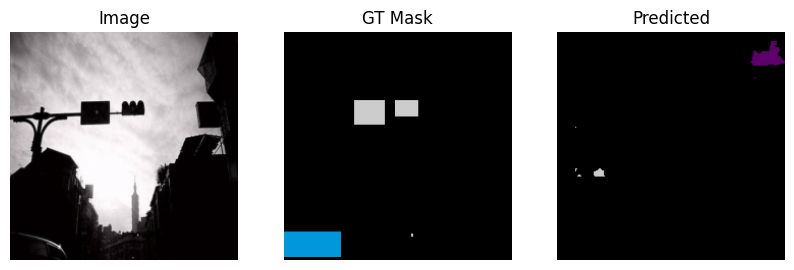

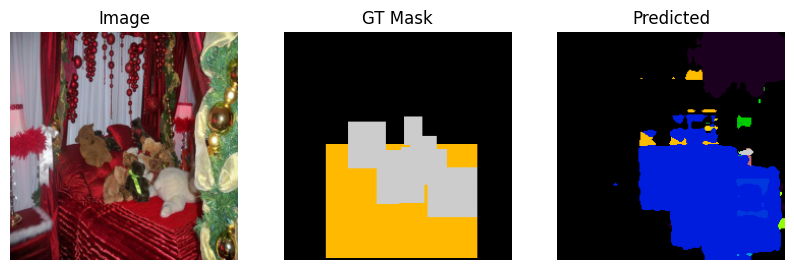

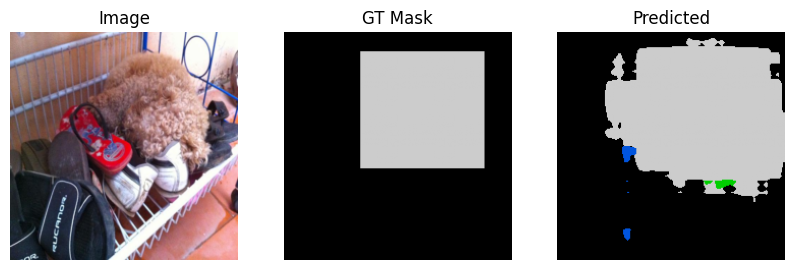


Visualization for fcn8_transpose_sgd


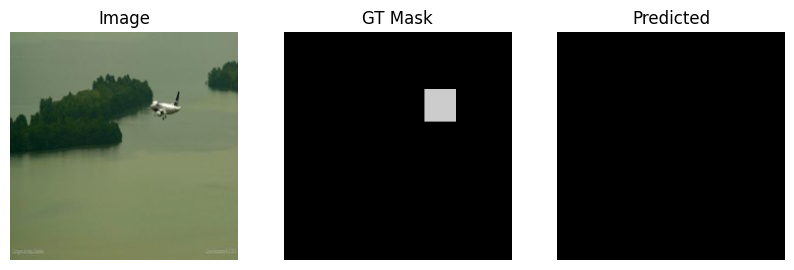

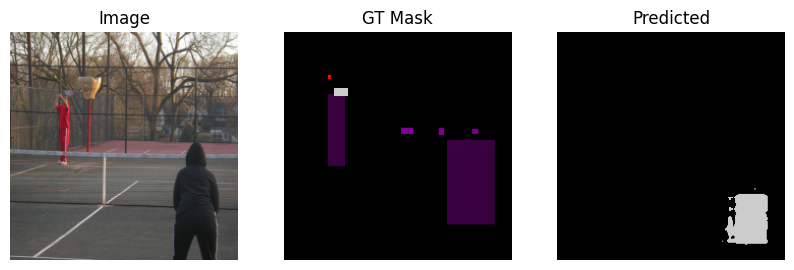

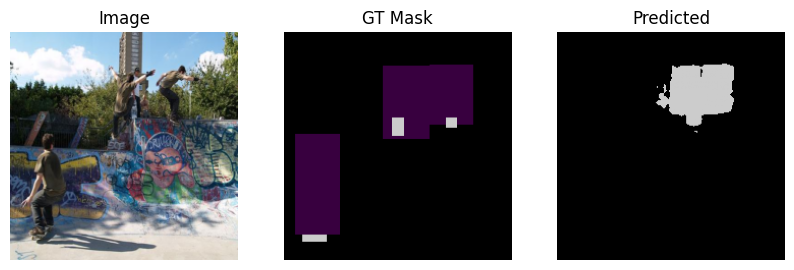


Visualization for fcn8_bilinear_adam


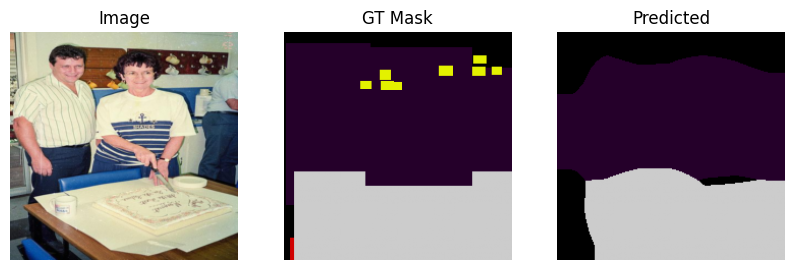

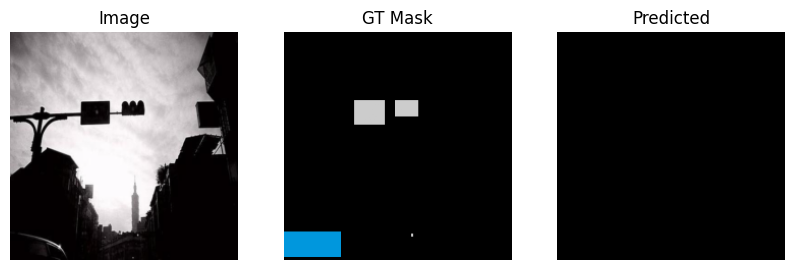

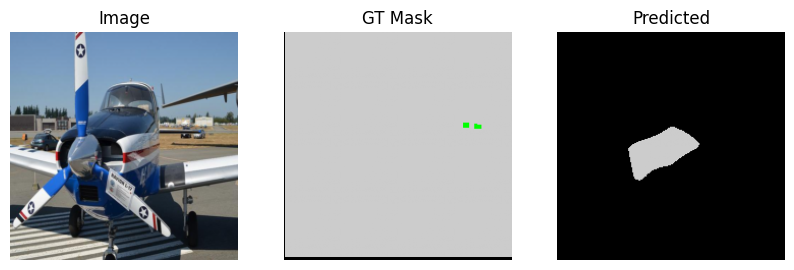


Visualization for fcn8_bilinear_sgd


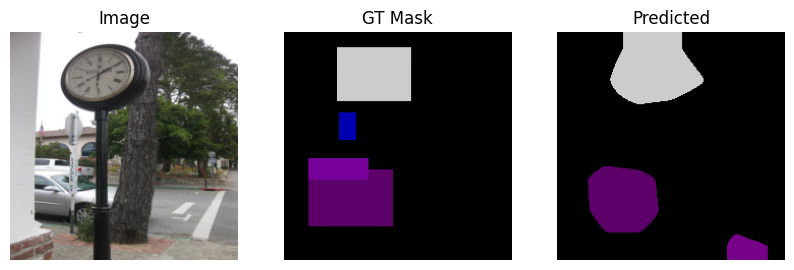

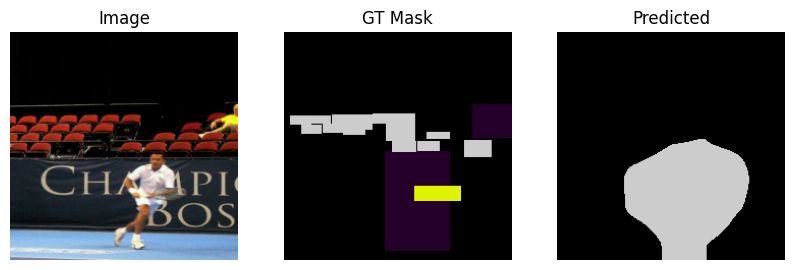

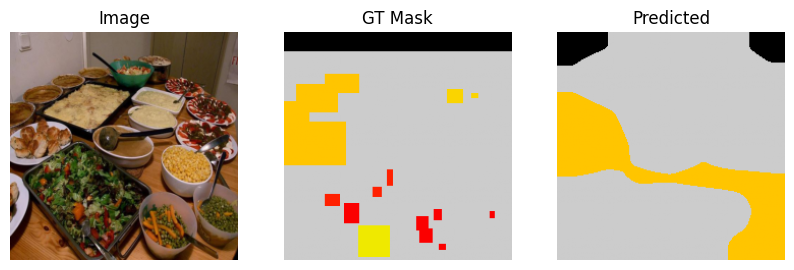

In [33]:
def visualize_all_models(trained_models, val_ds, num_classes):
    for key, model in trained_models.items():
        print("\n=============================")
        print(f"Visualization for {key}")
        visualize_results(model, val_ds.dataset if isinstance(val_ds, torch.utils.data.Subset) else val_ds, DEVICE, n=3, num_classes=num_classes)

visualize_all_models(trained_models, val_ds, num_classes)


### Print full comparison table (all models + optimizers)

In [35]:
def print_full_comparison(results_df):
    print("\n=== Full Upsampling Comparison Table ===")
    # Display the full DataFrame as is
    display(results_df)
    return results_df


comparison_df = print_full_comparison(results_df)



=== Full Upsampling Comparison Table ===


Model   Upsample Optimizer  Val_Loss  Pixel_Acc  Mean_IoU
0   fcn32  transpose      adam  3.067571   0.537515  0.058937
1   fcn32  transpose       sgd  2.633608   0.509010  0.059953
2   fcn32   bilinear      adam  3.340498   0.547937  0.106910
3   fcn32   bilinear       sgd  2.627441   0.513356  0.086225
4   fcn16  transpose      adam  3.415297   0.554795  0.083694
5   fcn16  transpose       sgd  2.684976   0.518410  0.063295
6   fcn16   bilinear      adam  3.481337   0.538260  0.085292
7   fcn16   bilinear       sgd  3.299095   0.513838  0.081400
8    fcn8  transpose      adam  3.037807   0.529748  0.073652
9    fcn8  transpose       sgd  2.714854   0.540939  0.081996
10   fcn8   bilinear      adam  3.376375   0.552319  0.097555
11   fcn8   bilinear       sgd  3.080625   0.537961  0.086089

### Discussion